In [1]:
import numpy as np
import pandas as pd
import math
from numba import jit, njit, prange
from tqdm import tqdm
import matplotlib.pyplot as plt
from tslearn.preprocessing import TimeSeriesScalerMinMax

In [2]:
data = np.loadtxt('lorenz.txt', dtype=np.float32)

In [23]:
x1 = 90000
x2 = 93000

train_data = data[:x1]
test_data = data[x1:x2]

### Largest Lyapunov Exponent, Rosenstein's method:

In [37]:
def LLE(ts, z_vector_dim=4, k=1, ts_length=10000, tau=0.1, eps = 1e-5):
    
    z_range = ts_length - z_vector_dim + 1
    z_vectors = np.zeros((z_range, z_vector_dim), dtype=np.float32)
    z_vectors_k = np.zeros((z_range, z_vector_dim), dtype=np.float32)

    for i in range(z_range):
        z_vectors[i] = np.array([ts[i], ts[i+1], ts[i+2], ts[i+3]])
        z_vectors_k[i] = np.array([ts[i+k], ts[i+k+1], ts[i+k+2], ts[i+k+3]])
    
    @jit(nopython=True, fastmath=True)
    def euc_dist(u, v):
        n = len(u)
        dist = 0
        for i in prange(n):
            dist += abs(u[i] - v[i]) ** 2 
        return dist ** (1 / 2)
    
    @njit(parallel=True)
    def vec_dist(z_vectors):
        m, n = z_vectors.shape
        dist = np.ones((m, m), dtype=np.float32)*2
        for i in prange(m):
            for j in prange(m):
                if i!=j:
                    dist[i,j] = euc_dist(z_vectors[i], z_vectors[j])
        return dist

    dists = vec_dist(z_vectors)
    dists_k = vec_dist(z_vectors_k)

    lyaps = np.zeros((z_range,), dtype=np.float32)
    for i in range(z_range):
        min_dist = np.min(dists[i])
        dist_idx =  np.where(dists[i] == min_dist)[0]
        lyaps[i] = np.log(dists_k[i][dist_idx]/(dists[i][dist_idx]+eps))[0]/(tau*k)

    lyap1 = np.mean(lyaps)
    return lyap1

### Largest Lyapunov Exponent for Lorenz time series:

In [16]:
%%time
LLE(train_data, z_vector_dim=4, k=1, ts_length=40000, tau=0.1, eps = 1e-5)

Wall time: 4.75 s


1.255526

In [21]:
import nolds

nolds.lyap_r(train_data, emb_dim=4, lag=1, min_tsep=1, tau=0.1, min_neighbors=20,
           trajectory_len=20, fit="RANSAC", debug_plot=False, debug_data=False,
           plot_file=None, fit_offset=0)

1.2063995303964252

In [24]:
lles = []
for i in tqdm(np.arange(1,500)):
    lles.append(LLE(train_data, z_vector_dim=4, k=i, ts_length=10000, tau=0.1, eps = 1e-5))

100%|████████████████████████████████████████████████████████████████████████████████| 499/499 [07:21<00:00,  1.13it/s]


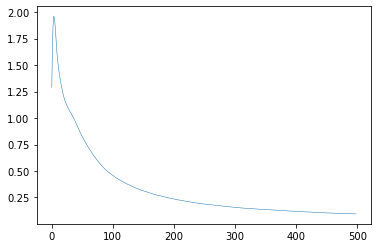

In [25]:
point = 499
x = np.arange(0, point)
y = lles[:point]
plt.plot(x, y, lw=0.5);

### Largest Lyapunov Exponent for financial time series:

In [26]:
# обучающая выборка для каждого дневного наблюдения из списка класса
data = pd.read_csv('IBM_15min_2y.csv') # откроем датасет
ts_df = data.sort_values(by=['time'], ascending=True)['close'].to_numpy() # возьмем adjusted цены закрытия 

ts_minmax = TimeSeriesScalerMinMax().fit_transform([ts_df]).ravel() # 0-1 масштабирование
ts_diff = np.diff(ts_minmax) # сделаем ряд стационарным через np.diff, очень важно ее сделать

x1 = 20000
x2 = 21000
train_data = ts_diff[:x1]
test_data = ts_diff[x1:x2]

min_ts = np.min(train_data) # для сдвига всей выборки вверх, отриц значения здесь недопустимы
train_data = train_data - np.full((train_data.shape[0], ), min_ts)

In [27]:
train_data.shape

(20000,)

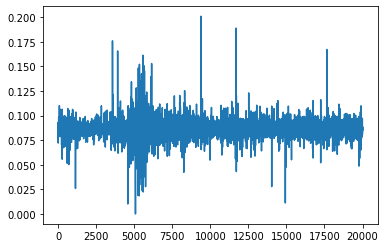

In [28]:
plt.plot(train_data)

In [44]:
%%time
LLE(train_data, z_vector_dim=4, k=1, ts_length=1000, tau=1, eps = 1e-5)

Wall time: 769 ms


0.8898132

In [50]:
np.seterr(divide='ignore', invalid='ignore')
lles_fin = []
for i in tqdm(np.arange(1,500)):
    lles_fin.append(LLE(train_data, z_vector_dim=4, k=i, ts_length=10000, tau=1, eps = 1e-5))

100%|████████████████████████████████████████████████████████████████████████████████| 499/499 [07:42<00:00,  1.08it/s]


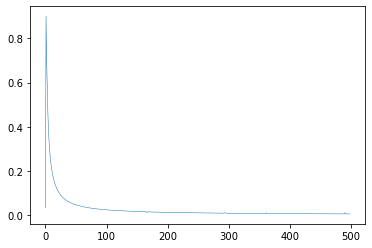

In [63]:
lles_fin = np.array(lles_fin)
lles_fin[np.isinf(lles_fin)]=0.01
lles_fin[:100][lles_fin[:100]==0.01]=0.033
point = 499
x = np.arange(0, point)
y = lles_fin[:point]
plt.plot(x, y, lw=0.5);